<a href="https://colab.research.google.com/github/Swethan-colab/Sonu27/blob/main/First_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [181]:
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim




In [275]:
import numpy as np
sequence_length = 5
# Define the number of data points
num_datapoints = 100
import torch

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create strain tensor
strains = torch.linspace(0, 100, 100, device=device).unsqueeze(1)
# Unsqueeze adds a new dimension at index 0, making it a 1xN tensor
# This is suitable for feeding into a single GRU sequence

# Generate random strains (adjustable range)
#strains = torch.rand(num_datapoints, sequence_length) * 10  # Strains between 0 and 10

# Simulate a linear elastic relationship between strain and stress (stress = constant * strain)
youngs_modulus = 73 # You can adjust this constant to control the slope of the relationship
stresses = strains * youngs_modulus
# Reshape for model input (batch_size, sequence_length, feature_size)
#strains = strains.unsqueeze(2)  # Add feature dimension
#stresses = stresses.unsqueeze(2)

print(stresses.shape)
def normalize(data):
  """
  Normalizes data to a range of [0, 1].

  Args:
      data (torch.Tensor): The data to be normalized.

  Returns:
      torch.Tensor: The normalized data.
  """
  min_val = torch.min(data)
  max_val = torch.max(data)
  return (data - min_val) / (max_val - min_val)
def z_score(data):
  return (data - data.mean()) / data.std()


torch.Size([100, 1])


In [276]:
#from sklearn.model_selection import train_test_split

# Splitting into training and testing sets (excluding validation for now)
X_train_val, X_test_, y_train_val, y_test_ = train_test_split(strains, stresses, test_size=0.1, random_state=42)

# Further split training and validation sets (from X_train_val and y_train_val)
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_val, y_train_val, test_size=0.16, random_state=42)

X_train = z_score(X_train_)
X_val = z_score(X_train_)
X_test = z_score(X_train_)

y_train = z_score(y_train_)
y_val = z_score(y_train_)
y_test = z_score(y_train_)

In [272]:
#train_size = 0.75
#val_size = 0.15
#test_size = 1-train_size - val_size
#train_set_size = int(strains.shape[1]*train_size)
#val_set_size = int(strains.shape[1]*val_size)
#test_set_size = strains.shape[1]-int(train_set_size+val_set_size)
#X_train = strains [:,:train_set_size ]
#X_val = strains [:,train_set_size:(train_set_size+val_set_size)]
#X_test = strains [:,(train_set_size+val_set_size):]

#y_train = stresses [:,:train_set_size ]
#y_val = stresses [:,train_set_size:(train_set_size+val_set_size)]
#y_test= stresses [:,(train_set_size+val_set_size):]
#print (X_train[0])

In [277]:
train_dataset = TensorDataset((X_train), (y_train))
val_dataset = TensorDataset((X_val), (y_val))
test_dataset = TensorDataset((X_test), (y_test))
batch_size=32
# Create data loaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




(tensor([[ 1.3076],
        [-1.3961],
        [-0.5283],
        [ 1.2742],
        [ 0.2394],
        [-0.7285]]), tensor([[ 1.3076],
        [-1.3961],
        [-0.5283],
        [ 1.2742],
        [ 0.2394],
        [-0.7285]]))


In [278]:
epochs = 100
batch_size = 32
patience = 5  # Early stopping patience
learning_rate = 0.001

In [279]:

def evaluate(model, val_dataloader, criterion):
    model.eval()  # Set model to evaluation mode (optional for some layers)
    with torch.no_grad():
        total_val_loss = 0
        for data, target in val_dataloader:
            output = model(data)
            val_loss = criterion(output, target)
            total_val_loss += val_loss.item()
    return total_val_loss / len(val_dataloader)


# Define the GRU model
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.gru1 = nn.GRU(input_size=1, hidden_size=32)  # Add activation='tanh'
    self.gru2 = nn.GRU(input_size=32, hidden_size=16)
    self.activation = nn.ReLU()  # Add activation='tanh'
    self.linear = nn.Linear(16, 1)

  def forward(self, x):
    x, _ = self.gru1(x)
    x = self.activation(x)  # Apply activation after GRU1
    x, _ = self.gru2(x)
    x = self.activation(x)  # Apply activation after GRU2
    x = self.linear(x)
    return x

# Create the model
model = MyModel()
criterion = nn.MSELoss()

# Define optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters())


# Function to calculate loss for a given data loader
def calculate_loss(data_loader, model, loss_fn):
  total_loss = 0
  for data, target in data_loader:
    predicted_stress = model(data)
    loss = loss_fn(predicted_stress, target)
    total_loss += loss.item()
  return total_loss / len(data_loader)



In [280]:
import matplotlib.pyplot as plt

def evaluate(model, val_dataloader, criterion):
    model.eval()  # Set model to evaluation mode (optional for some layers)
    with torch.no_grad():
        total_val_loss = 0
        for data, target in val_dataloader:
            output = model(data)
            val_loss = criterion(output, target)
            total_val_loss += val_loss.item()
    return total_val_loss / len(val_dataloader)

def train_model(model, train_loader, val_loader, epochs, patience):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adjust optimizer
    criterion = nn.MSELoss()  # Mean Squared Error loss

    training_losses = []  # Store training losses for each epoch
    validation_losses = []  # Store validation losses for each epoch

    best_val_loss = float('inf')
    for epoch in range(epochs):
        # Train loop
        total_train_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()  # Reset gradients for each batch

            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Calculate and print average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

        # Validation
        val_loss = evaluate(model, val_dataloader, criterion)
        validation_losses.append(val_loss)
        print(f"Val Loss: {val_loss:.4f}")

        # Early stopping (implementation not shown here for brevity)

    # Plot training and validation loss (after training)
    plt.plot(range(epochs), training_losses, label='Training Loss')
    plt.plot(range(epochs), validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Load best model weights (implementation not shown here for brevity)
    return model

Epoch 1/30, Train Loss: 0.9961
Val Loss: 1.0549
Epoch 2/30, Train Loss: 0.9137
Val Loss: 1.0499
Epoch 3/30, Train Loss: 0.9407
Val Loss: 1.0450
Epoch 4/30, Train Loss: 0.8988
Val Loss: 1.0406
Epoch 5/30, Train Loss: 0.9756
Val Loss: 1.0365
Epoch 6/30, Train Loss: 0.9050
Val Loss: 1.0324
Epoch 7/30, Train Loss: 0.9692
Val Loss: 1.0285
Epoch 8/30, Train Loss: 1.0007
Val Loss: 1.0239
Epoch 9/30, Train Loss: 0.9407
Val Loss: 1.0191
Epoch 10/30, Train Loss: 0.9219
Val Loss: 1.0132
Epoch 11/30, Train Loss: 0.8641
Val Loss: 1.0066
Epoch 12/30, Train Loss: 0.9216
Val Loss: 0.9989
Epoch 13/30, Train Loss: 0.9629
Val Loss: 0.9909
Epoch 14/30, Train Loss: 1.0115
Val Loss: 0.9819
Epoch 15/30, Train Loss: 0.9114
Val Loss: 0.9725
Epoch 16/30, Train Loss: 0.8583
Val Loss: 0.9615
Epoch 17/30, Train Loss: 0.8978
Val Loss: 0.9492
Epoch 18/30, Train Loss: 0.9771
Val Loss: 0.9347
Epoch 19/30, Train Loss: 0.8301
Val Loss: 0.9186
Epoch 20/30, Train Loss: 0.8143
Val Loss: 0.9003
Epoch 21/30, Train Loss: 0.87

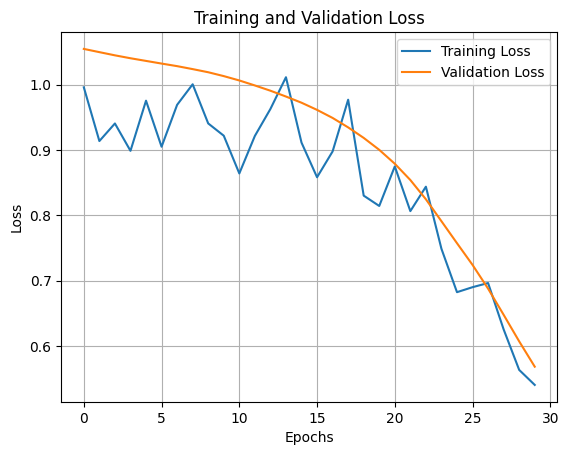

MyModel(
  (gru1): GRU(1, 32)
  (gru2): GRU(32, 16)
  (activation): ReLU()
  (linear): Linear(in_features=16, out_features=1, bias=True)
)

In [281]:
train_model(model,train_dataloader,val_dataloader,30,5)